In [1]:
import os, sys, warnings, time, memory_profiler
import numpy as np, matplotlib.pyplot as plt
from sequentia import *
from tqdm.auto import tqdm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Flatten

# Silence TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Import utility functions and classes
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils import *
from nn import NNClassifier

# Filter warnings
warnings.filterwarnings('ignore')

# ggplot style
plt.style.use('ggplot')

# Set seed for reproducible randomness
seed = 0
np.random.seed(seed)
rng = np.random.RandomState(seed=seed)

In [2]:
gestures_map = {
    'nd': 'nod',
    'mnd': 'multiple nods',
    'fu': 'face-up',
    'fd': 'face-down',
    'sh': 'shake',
    't': 'turn',
    'ti': 'tilt'
}

gestures = list(gestures_map.keys())

In [3]:
fields = ['Rx', 'Ry', 'Rz']

In [4]:
# Containers to store classifiers and results
clfs, results = {}, {'hmm': {}, 'knn': {}, 'ffnn': {}, 'lstm': {}}

In [5]:
# Load the MoCap dataset
loader = MoCapLoader(normalized=False)
X, y = loader.load(fields)

## Dataset splits

Create a stratified 65-20-15 training, validation and test set split.

In [6]:
# Create a stratified training, validation and test set split (65-20-15)
X_train, X_val, X_test, y_train, y_val, y_test = data_split(X, y, (65, 20, 15), random_state=rng, stratify=True)

Training set size: 841
Validation set size: 259
Test set size: 195


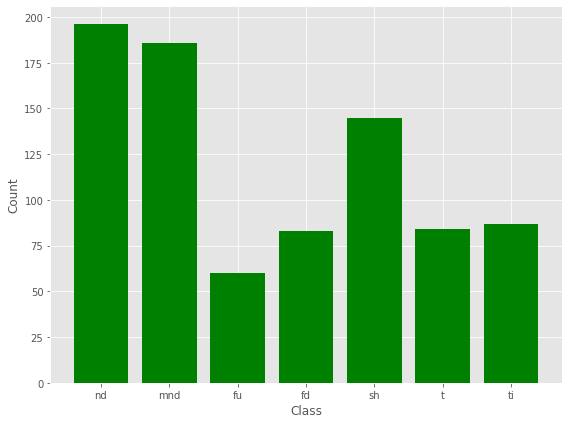

In [7]:
# MoCap dataset class counts (training set)
show_class_counts(y_train, gestures, title=None)

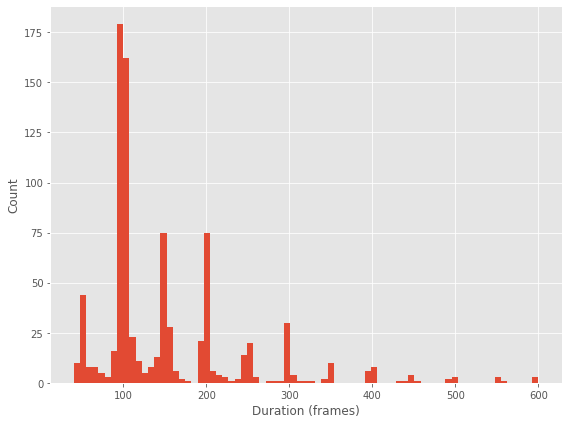

In [8]:
# Histogram of MoCap dataset gesture durations (training set)
show_durations(X_train, bins=75, title=None)

## Preprocessing

In [9]:
# Create a preprocessing pipeline
pre = Preprocess([
    Filter(window_size=10, method='median'),
    BinDownsample(bin_size=50, method='decimate'),
    Center()
])
pre.summary()

             Preprocessing summary:            
1. Filter
   Median filtering with window-size 10
-----------------------------------------------
2. BinDownsample
   Decimation bin-downsampling with bin-size 50
-----------------------------------------------
3. Center
   Centering around mean (zero mean)


In [10]:
# Function for visualizing gesture signals
def plot_gesture(gesture, label, figsize=(7, 5), same_scale=True):
    labels = ['$\\varphi^{(t)}_x$', '$\\varphi^{(t)}_y$', '$\\varphi^{(t)}_z$']
    colors = ['blue', 'red', 'green']
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=figsize)
    
    for i, ax in enumerate(axs.flat):
        ax.plot(gesture[:, i], color=colors[i])
        ax.set_ylabel(labels[i], rotation=0, labelpad=7, fontsize=14)
        if same_scale:
            pad = 0.05
            ax.set_ylim(gesture.min()-pad, gesture.max()+pad)
    ax.set_xlabel('Duration (frames)')
        
    fig.tight_layout()
#     plt.savefig('plots/example-rotation-signal.pdf')
    plt.show()

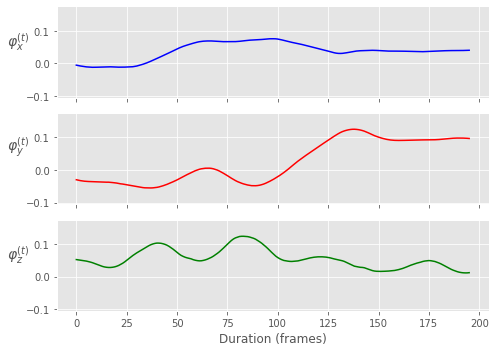

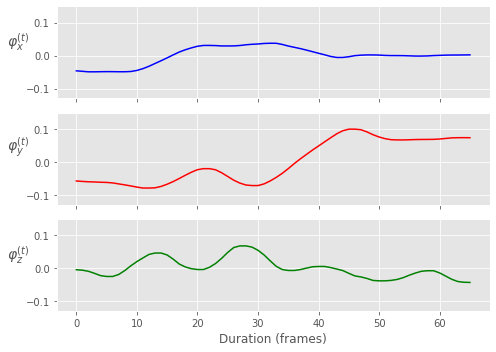

In [11]:
# Pick an example signal for visualization
x_sample, y_sample = X_train[1], y_train[1]
plot_gesture(x_sample, y_sample)
plot_gesture(pre.transform(x_sample), y_sample)

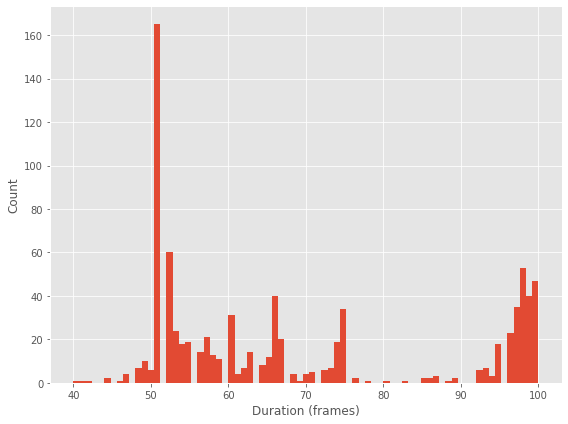

In [12]:
# Transform training data and plot histogram of MoCap dataset gesture durations (training set)
Xp_train = pre.fit_transform(X_train, verbose=True)
show_durations(Xp_train, bins=75, title=None)

In [13]:
# Apply the preprocessing pipeline to the other dataset splits
Xp_val, Xp_test = pre.transform(X_val, verbose=True), pre.transform(X_test, verbose=True)

## DTWKNN classifier

### Fitting the model

### Evaluating the model

## Hidden Markov Model classifier

One gesture model $\lambda_i=(A_i,B_i,\pi_i)$ is initialized and trained for each of the gestures: `nd`, `mnd`, `sh`, `fd`, `t`, `ti`, `fu`.

### Training the model

### Evaluating the model

## Feedforward Neural Network classifier

### Fitting the model

### Evaluating the model

## LSTM classifier

### Fitting the model

### Evaluating the model

# Final experiments

## HMM

## DTWKNN

### Radius parameter

### Neighborhood parameter ($k$)

## FFNN

## LSTM

In [ ]:
for repeat in range(5):
    seed = repeat
    np.random.seed(seed)
    rng = np.random.RandomState(seed=seed)
    
    X_train, X_val, X_test, y_train, y_val, y_test = data_split(X, y, (65, 20, 15), random_state=rng, stratify=True)
    Xp_train = pre.fit_transform(X_train, verbose=True)
    Xp_val, Xp_test = pre.transform(X_val, verbose=True), pre.transform(X_test, verbose=True)
    
    for n_layers in (1, 2, 3):
        for h_dim in (100, 200, 300):
    
            clf = None
            running_stats = {'fit': {}, 'predict': {}}

            def fit():
                clf = NNClassifier(epochs=500, batch_size=128, optimizer=Adam(learning_rate=0.002), classes=gestures)
                
                arch = []
                for _ in range(n_layers - 1):
                    arch.append(Bidirectional(LSTM(h_dim, return_sequences=True, recurrent_dropout=0.5)))
                arch.append(Bidirectional(LSTM(h_dim, recurrent_dropout=0.5)))
                arch.append(Dense(100, activation='relu'))
                arch.append(Dense(len(gestures), activation='softmax'))
                
                hist = clf.fit(arch, Xp_train, y_train, validation_data=(Xp_val, y_val), return_history=True, verbose=2, patience=40)
                return clf, hist

            t0 = time.time()
            mem, out = memory_profiler.memory_usage(fit, retval=True)
            clf, hist = out
            running_stats['fit']['memory'] = max(mem)
            running_stats['fit']['time'] = time.time() - t0

            def evaluate():
                return clf.evaluate(Xp_val, y_val)

            t0 = time.time()
            mem, res = memory_profiler.memory_usage(evaluate, retval=True)
            running_stats['predict']['memory'] = max(mem)
            running_stats['predict']['time'] = time.time() - t0
            results['lstm']['validation'] = res

            # Write the results
            write_network_results('lstm', results, hist, running_stats, '{}layers {}h_dim'.format(n_layers, h_dim), 'validation', number=repeat)